In [1]:
import pandas as pd
import numpy as np
import time

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.linear_model import LogisticRegression
%load_ext sql

%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

%sql duckdb:///:memory:

__Introduction:__
<br><br>
My group has decided to research crime in the state of New York. We would like to focus our analysis on "hot spots" (i.e., the counties or regions where crime has historically occured most often). To do this, we will first identify the top 5 counties with the highest number of reported crime incidents in around the past 10 years. We will also look for patterns surrounding the crime incidents, such as recent upticks or dips in crime over time. We will finally examine the most common types of reported crimes and arrests in those counties, as well as the people who have been arrested (whether fairly or unfairly) for those crimes.


__Research question(s):__
<br>
<br> 1. What general trends characterize the counties in New York State that have the highest rates of crime?
<br> 2. Among those counties, what types of crime are people most likely to be arrested for, and what demographics do those people fall under?

__Data collection and cleaning:__
<br>
<br> We used two datasets to start our analysis. The first, Index Crimes by County and Agency: Beginning 1990, contains data from police reports filed in all New York counties. The second, NYPD Arrests Data, lists every arrest in NYC from 2006 to 2021.

In [2]:
#storing the .csv files as dataframes
county_crime_dataset = pd.read_csv('Index_Crimes_by_County_and_Agency__\
Beginning_1990.csv')
nypd_arrests_dataset = pd.read_csv('NYPD_Arrests_Data__Historic_.csv')

In [3]:
county_crime_dataset.head()

,County,Agency,Year,Months Reported,Index Total,Violent Total,Murder,Rape,Robbery,Aggravated Assault,Property Total,Burglary,Larceny,Motor Vehicle Theft,Region
0,Albany,Albany City PD,1990,NaN,6635.0,1052.0,9.0,82.0,386.0,575.0,5583.0,1884.0,3264.0,435.0,Non-New York City
1,Albany,Albany City PD,1991,NaN,7569.0,1201.0,11.0,71.0,487.0,632.0,6368.0,1988.0,3878.0,502.0,Non-New York City
2,Albany,Albany City PD,1992,NaN,7791.0,1150.0,8.0,77.0,467.0,598.0,6641.0,2246.0,3858.0,537.0,Non-New York City
3,Albany,Albany City PD,1993,NaN,7802.0,1238.0,6.0,59.0,481.0,692.0,6564.0,2063.0,4030.0,471.0,Non-New York City
4,Albany,Albany City PD,1994,NaN,8648.0,1380.0,13.0,79.0,542.0,746.0,7268.0,2227.0,4502.0,539.0,Non-New York City


In [4]:
nypd_arrests_dataset.head()

,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lon_Lat
0,236791704,11/22/2021,581.0,NaN,NaN,NaN,PL 2225001,M,M,28,0.0,45-64,M,BLACK,997427.0,230378.0,40.799009,-73.952409,POINT (-73.95240854099995 40.799008797000056)
1,237354740,12/04/2021,153.0,RAPE 3,104.0,RAPE,PL 1302502,F,B,41,0.0,25-44,M,WHITE HISPANIC,1013232.0,236725.0,40.816392,-73.895296,POINT (-73.89529641399997 40.816391847000034)
2,236081433,11/09/2021,681.0,"CHILD, ENDANGERING WELFARE",233.0,SEX CRIMES,PL 2601001,M,Q,113,0.0,25-44,M,BLACK,1046367.0,186986.0,40.679700,-73.776047,POINT (-73.77604736799998 40.67970040800003)
3,32311380,06/18/2007,511.0,"CONTROLLED SUBSTANCE, POSSESSION 7",235.0,DANGEROUS DRUGS,PL 2200300,M,Q,27,1.0,18-24,M,BLACK,NaN,NaN,NaN,NaN,NaN
4,192799737,01/26/2019,177.0,SEXUAL ABUSE,116.0,SEX CRIMES,PL 1306503,F,M,25,0.0,45-64,M,BLACK,1000555.0,230994.0,40.800694,-73.941109,POINT (-73.94110928599997 40.800694331000045)


We converted the dates in the ARREST_DATE column to DateTime values so we could easily access the time of the arrests. Also, because the reports in county_crime_dataset are listed by year, we added a YEAR column to nypd_arrests_dataset to more easily compare statistics among the two datasets. 

In [5]:
nypd_arrests_dataset['ARREST_DATE'] = pd.to_datetime(nypd_arrests_dataset['ARREST_DATE'], format='%m/%d/%Y')
nypd_arrests_dataset['YEAR'] = nypd_arrests_dataset['ARREST_DATE'].dt.year
nypd_arrests_dataset.head()

,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lon_Lat,YEAR
0,236791704,2021-11-22,581.0,NaN,NaN,NaN,PL 2225001,M,M,28,0.0,45-64,M,BLACK,997427.0,230378.0,40.799009,-73.952409,POINT (-73.95240854099995 40.799008797000056),2021
1,237354740,2021-12-04,153.0,RAPE 3,104.0,RAPE,PL 1302502,F,B,41,0.0,25-44,M,WHITE HISPANIC,1013232.0,236725.0,40.816392,-73.895296,POINT (-73.89529641399997 40.816391847000034),2021
2,236081433,2021-11-09,681.0,"CHILD, ENDANGERING WELFARE",233.0,SEX CRIMES,PL 2601001,M,Q,113,0.0,25-44,M,BLACK,1046367.0,186986.0,40.679700,-73.776047,POINT (-73.77604736799998 40.67970040800003),2021
3,32311380,2007-06-18,511.0,"CONTROLLED SUBSTANCE, POSSESSION 7",235.0,DANGEROUS DRUGS,PL 2200300,M,Q,27,1.0,18-24,M,BLACK,NaN,NaN,NaN,NaN,NaN,2007
4,192799737,2019-01-26,177.0,SEXUAL ABUSE,116.0,SEX CRIMES,PL 1306503,F,M,25,0.0,45-64,M,BLACK,1000555.0,230994.0,40.800694,-73.941109,POINT (-73.94110928599997 40.800694331000045),2019


Since our datasets covered different time periods, we wanted to make our datasets start and end at the same time.

In [6]:
#Selecting data with years starting from 2008 and ending in 2021
%sql county_2008 << SELECT * \
FROM county_crime_dataset \
WHERE Year >= 2008 AND Year <= 2021 \
ORDER BY Year ASC
county_2008.head()
county_2008.tail()

Returning data to local variable county_2008


,County,Agency,Year,Months Reported,Index Total,Violent Total,Murder,Rape,Robbery,Aggravated Assault,Property Total,Burglary,Larceny,Motor Vehicle Theft,Region
9088,Wyoming,Wyoming County State Police,2021,12.0,50.0,16.0,0.0,8.0,0.0,8.0,34.0,6.0,26.0,2.0,Non-New York City
9089,Yates,County Total,2021,NaN,182.0,34.0,0.0,21.0,0.0,13.0,148.0,14.0,127.0,7.0,Non-New York City
9090,Yates,Penn Yan Vg PD,2021,12.0,75.0,12.0,0.0,11.0,0.0,1.0,63.0,4.0,58.0,1.0,Non-New York City
9091,Yates,Yates County Sheriff,2021,12.0,95.0,19.0,0.0,7.0,0.0,12.0,76.0,10.0,62.0,4.0,Non-New York City
9092,Yates,Yates County State Police,2021,12.0,12.0,3.0,0.0,3.0,0.0,0.0,9.0,0.0,7.0,2.0,Non-New York City


In [7]:
nypd_arrests_2008 = nypd_arrests_dataset[(nypd_arrests_dataset \
['YEAR'] >= 2008) & (nypd_arrests_dataset \
['YEAR'] <= 2021)]
nypd_arrests_2008.head()
nypd_arrests_2008.tail()

,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lon_Lat,YEAR
4801632,37566445,2008-01-08,567.0,"MARIJUANA, POSSESSION 4 & 5",235.0,DANGEROUS DRUGS,PL 2211001,M,Q,114,0.0,25-44,M,WHITE,1006898.0,220358.0,40.771487,-73.918235,POINT (-73.91823481899996 40.771487379000064),2008
4801633,37565060,2008-01-08,511.0,"CONTROLLED SUBSTANCE, POSSESSION 7",235.0,DANGEROUS DRUGS,PL 2200300,M,B,41,0.0,45-64,M,WHITE HISPANIC,1015927.0,236094.0,40.814651,-73.885563,POINT (-73.88556301199996 40.81465067700003),2008
4801638,37543923,2008-01-07,205.0,"TRESPASS 2, CRIMINAL",352.0,CRIMINAL TRESPASS,PL 1401500,M,B,42,0.0,<18,M,BLACK,1016142.0,243637.0,40.835353,-73.884750,POINT (-73.88475043899997 40.83535328100004),2008
4801644,37640214,2008-01-11,478.0,"THEFT OF SERVICES, UNCLASSIFIED",343.0,OTHER OFFENSES RELATED TO THEFT,PL 1651503,M,K,73,0.0,<18,M,BLACK,1005571.0,181640.0,40.665219,-73.923148,POINT (-73.92314834999998 40.66521910700004),2008
4801646,37688843,2008-01-14,905.0,"INTOXICATED DRIVING,ALCOHOL",347.0,INTOXICATED & IMPAIRED DRIVING,VTL11920M2,M,Q,109,0.0,18-24,M,ASIAN / PACIFIC ISLANDER,1030489.0,214264.0,40.754669,-73.833106,POINT (-73.83310572199997 40.75466902800008),2008


In [8]:
nypd_arrests_2008

,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lon_Lat,YEAR
0,236791704,2021-11-22,581.0,NaN,NaN,NaN,PL 2225001,M,M,28,0.0,45-64,M,BLACK,997427.0,230378.0,40.799009,-73.952409,POINT (-73.95240854099995 40.799008797000056),2021
1,237354740,2021-12-04,153.0,RAPE 3,104.0,RAPE,PL 1302502,F,B,41,0.0,25-44,M,WHITE HISPANIC,1013232.0,236725.0,40.816392,-73.895296,POINT (-73.89529641399997 40.816391847000034),2021
2,236081433,2021-11-09,681.0,"CHILD, ENDANGERING WELFARE",233.0,SEX CRIMES,PL 2601001,M,Q,113,0.0,25-44,M,BLACK,1046367.0,186986.0,40.679700,-73.776047,POINT (-73.77604736799998 40.67970040800003),2021
4,192799737,2019-01-26,177.0,SEXUAL ABUSE,116.0,SEX CRIMES,PL 1306503,F,M,25,0.0,45-64,M,BLACK,1000555.0,230994.0,40.800694,-73.941109,POINT (-73.94110928599997 40.800694331000045),2019
5,193260691,2019-02-06,NaN,NaN,NaN,NaN,PL 2203400,F,M,14,0.0,25-44,M,UNKNOWN,986685.0,215375.0,40.757839,-73.991212,POINT (-73.99121211099998 40.75783900300007),2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4801632,37566445,2008-01-08,567.0,"MARIJUANA, POSSESSION 4 & 5",235.0,DANGEROUS DRUGS,PL 2211001,M,Q,114,0.0,25-44,M,WHITE,1006898.0,220358.0,40.771487,-73.918235,POINT (-73.91823481899996 40.771487379000064),2008
4801633,37565060,2008-01-08,511.0,"CONTROLLED SUBSTANCE, POSSESSION 7",235.0,DANGEROUS DRUGS,PL 2200300,M,B,41,0.0,45-64,M,WHITE HISPANIC,1015927.0,236094.0,40.814651,-73.885563,POINT (-73.88556301199996 40.81465067700003),2008
4801638,37543923,2008-01-07,205.0,"TRESPASS 2, CRIMINAL",352.0,CRIMINAL TRESPASS,PL 1401500,M,B,42,0.0,<18,M,BLACK,1016142.0,243637.0,40.835353,-73.884750,POINT (-73.88475043899997 40.83535328100004),2008
4801644,37640214,2008-01-11,478.0,"THEFT OF SERVICES, UNCLASSIFIED",343.0,OTHER OFFENSES RELATED TO THEFT,PL 1651503,M,K,73,0.0,<18,M,BLACK,1005571.0,181640.0,40.665219,-73.923148,POINT (-73.92314834999998 40.66521910700004),2008


We dropped the columns that did not directly relate to our research questions. For example, many of the columns concerning internal/legal codes were dropped from the nypd_arrests dataset.

In [9]:
#Dropping columns from the county crime dataset
county_drop_cols = ['Months Reported']
county_crime = county_2008.drop(county_drop_cols, axis = 1)
#Dropping columns from the NYPD arrests dataset
nypd_arrests_drop_cols = ['ARREST_KEY','PD_CD', 'PD_DESC', 'KY_CD', 'LAW_CODE', 'LAW_CAT_CD', 'ARREST_PRECINCT', 'JURISDICTION_CODE']
nypd_arrests = nypd_arrests_2008.drop(nypd_arrests_drop_cols, axis = 1)

In [10]:
county_crime.head()

,County,Agency,Year,Index Total,Violent Total,Murder,Rape,Robbery,Aggravated Assault,Property Total,Burglary,Larceny,Motor Vehicle Theft,Region
0,Albany,Albany City PD,2008,5490.0,1061.0,10.0,48.0,372.0,631.0,4429.0,1034.0,3170.0,225.0,Non-New York City
1,Albany,Albany County (RR-CSX),2008,5.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0,0.0,Non-New York City
2,Albany,Albany County Park PD,2008,3.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,2.0,0.0,Non-New York City
3,Albany,Albany County Sheriff,2008,136.0,33.0,0.0,4.0,3.0,26.0,103.0,28.0,74.0,1.0,Non-New York City
4,Albany,Albany County State Police,2008,239.0,18.0,0.0,4.0,1.0,13.0,221.0,18.0,199.0,4.0,Non-New York City


In [11]:
nypd_arrests.head()

,ARREST_DATE,OFNS_DESC,ARREST_BORO,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lon_Lat,YEAR
0,2021-11-22,NaN,M,45-64,M,BLACK,997427.0,230378.0,40.799009,-73.952409,POINT (-73.95240854099995 40.799008797000056),2021
1,2021-12-04,RAPE,B,25-44,M,WHITE HISPANIC,1013232.0,236725.0,40.816392,-73.895296,POINT (-73.89529641399997 40.816391847000034),2021
2,2021-11-09,SEX CRIMES,Q,25-44,M,BLACK,1046367.0,186986.0,40.679700,-73.776047,POINT (-73.77604736799998 40.67970040800003),2021
4,2019-01-26,SEX CRIMES,M,45-64,M,BLACK,1000555.0,230994.0,40.800694,-73.941109,POINT (-73.94110928599997 40.800694331000045),2019
5,2019-02-06,NaN,M,25-44,M,UNKNOWN,986685.0,215375.0,40.757839,-73.991212,POINT (-73.99121211099998 40.75783900300007),2019


__Data description:__
* Our first dataset, county_crime, has 14 columns and 21.8K rows. Its data came from the "Index Crimes by County and Agency: Beginning 1990" dataset. Each row represents a crime report submitted between 1990 and 2021 to The Division of Criminal Justice Services by a New York State police or sheriff department. The columns describe the crimes present in that report, such as the county the crimes were committed in, the year, the # of total crimes, the # of violent crimes, the # of murders, etc. The Index Crimes dataset was created by the Division of Criminal Justice Services, and its creation was funded by said department. Furthermore, the Index Crimes dataset was submitted to the FBI under the National Uniform Crime Reporting (UCR) Program, to generate statistics in use for law enforcement across the nation. The data itself may be influenced by which populations are more likely to report a crime to the police, as well as which crimes are more likely to reported. In creating the county_crime dataset, we modified the Index Crimes dataset to exclude the Months Reported column, as we will mainly be focusing on the number and location of various crimes. We also excluded crime reports/rows submitted before 2008 to focus on crime in more recent years, and to accelerate the speed of our data analysis process. Link to the raw source data: https://catalog.data.gov/dataset/index-crimes-by-county-and-agency-beginning-1990
<br><br>_Columns:_ 
* County - Location where the crime was reported.
* Agency - Police Department that reported the crime.
* Year - Year the crime incident was reported.
* Months Reported - Number of months an individual agency reported for the year.
* Index Total - Includes sum of Murder, Rape, Robbery, Aggravated Assault, Burglary, Larceny and Motor Vehicle Theft.
* Violent Total	- Subtotal includes Murder, Rape, Robbery and Aggravated Assault.
* Murder - One count per victim. The willful killing of one human being by another. Excludes deaths caused by negligence, suicide, or justifiable homicides, and attempts to murder, which are classified as assault.
* Rape - One count per victim. Penetration, no matter how slight, of the vagina or anus with any body part or object, or oral penetration by a sex organ of another person, without the consent of the victim.
* Robbery - One count per victim. The taking or attempting to take anything of value from the care, custody, or control of a person or persons by force or threat of force or violence and/or by putting the victim in fear.
* Aggravated Assault - One count per victim. The unlawful attack by one person upon another for the purpose of inflicting severe or aggravated bodily injury. This type of assault is usually accompanied by the use of a weapon or by means likely to produce death or great bodily harm, and also includes attempts to commit murder.
* Property Total - Subtotal includes Burglary, Larceny and Motor Vehicle Theft.
* Burglary - One count per victim. The unlawful entry of a structure to commit a felony or theft. The use of force to gain entry is not required to classify an offense as Burglary.
* Larceny - One count per victim. The unlawful taking, carrying, leading, or riding away of property from the possession or constructive possession of another. It includes crimes such as shoplifting, purse snatching, bicycle thefts, etc., in which no use of force, violence, or fraud occurs. This offense category does not include offenses such as embezzlement, forgery, or bad checks.
* Motor Vehicle Theft - One count per victim. The theft or attempted theft of a motor vehicle, including automobiles, trucks, buses, motorcycles, and snowmobiles.
* Region - Region where the crime was reported. Regions include New York City (Bronx, Kings, New York, Queens, and Richmond counties) and Non-New York City (all other counties).
<br><br>
* Our second dataset, nypd_arrests, has 13 columns and 5.31M rows.  Its data came from the "NYPD Arrests Data (Historic)" dataset. Each row represents a NYPD arrest that took place in NYC. The columns describe the arrests with data such as location, date, and the race, gender, and age of the perpetrator. This dataset was funded by the NYPD and created for two reasons: to allow the public to examine police enforcement activity, and to support efficient policing in NYC. The observed data is manually extracted every quarter and reviewed by the NYPD's Office of Management Analysis and Planning before being posted on the NYPD website. The observed data may be influenced by biases in law enforcement, as discrimination could cause a disproportionate number of minorities to be unfairly arrested. In creating the nypd_arrests dataset, we modified the NYPD Arrests dataset to exclude any columns that did not contain details regarding the date, location, type of crime, or perpetrator of the arrest. We also excluded arrests before 2008 to match the years present in our county_crime dataset. Link to the raw source data: https://data.cityofnewyork.us/Public-Safety/NYPD-Arrest-Data-Year-to-Date-/uip8-fykc
<br><br>_Columns:_
* ARREST_DATE - Exact date of arrest for the reported event.
* OFNS_DESC	- Description of internal classification corresponding with KY code (more general category than PD description).
* ARREST_BORO - Borough of arrest. B(Bronx), S(Staten Island), K(Brooklyn), M(Manhattan), Q(Queens)
* AGE_GROUP	- Perpetrator’s age within a category.
* PERP_SEX - Perpetrator’s sex description.
* PERP_RACE	- Perpetrator’s race description.
* X_COORD_CD - Midblock X-coordinate for New York State Plane Coordinate System, Long Island Zone, NAD 83, units feet (FIPS 3104).
* Y_COORD_CD - Midblock Y-coordinate for New York State Plane Coordinate System, Long Island Zone, NAD 83, units feet (FIPS 3104).
* Latitude - Latitude coordinate for Global Coordinate System, WGS 1984, decimal degrees (EPSG 4326).
* Longitude	- Longitude coordinate for Global Coordinate System, WGS 1984, decimal degrees (EPSG 4326).
* Lon_Lat - The (longitude, latitude) point of the arrest.
* YEAR - The year of the arrest.

__Data limitations:__ 
<br><br>
It must be acknowledged that our county_crime dataset is not indicative of the actual crimes committed in New York State, as many crimes happen, but not all are reported. Recent studies from the Pew Research Center (https://www.pewresearch.org/fact-tank/2020/11/20/facts-about-crime-in-the-u-s/) have shown that auto theft is the most likely crime to reported in the U.S. (at a rate of around 80%). Thus, our county_crime data may be represented by a disproportionally high number of property crimes. And among violent crimes, crimes such as sexual assault are reported at significantly lower rates (around 30%) compared to crimes such as  aggravated assault, which is the most likely violent crime to be reported to law enforcement (at a rate of around 50%). Additionally, White people are significantly more likely to call the police to report a crime (https://counciloncj.foleon.com/policing/assessing-the-evidence/policing-by-the-numbers/). As a result, the crimes committed in locations with a high population of minorities may not be fully represented by our county_crime dataset.
<br><br>
Our nypd_arrests dataset contains similiar limitations. Not all reported crimes are solved or lead to an arrest, so differences between the county_crime and nypd_arrests dataset are inevitable, making it difficult to combine the two datasets into a sensible common dataset. For example, in the U.S., murder is the most likely crime to be solved, while auto theft, the most reported crime, is not as likely to be solved as aggrevated assault and robbery (https://www.pewresearch.org/fact-tank/2020/11/20/facts-about-crime-in-the-u-s/). Furthermore, there has traditionally been a disparity between Black and White arrest rates for violent crimes and drug offenses, with Black people remaining far more likely to be arrested for violent and drug offenses than White people (https://counciloncj.foleon.com/policing/assessing-the-evidence/policing-by-the-numbers/). Our nypd_arrests dataset consists of only basic information about the arrests, and lacks information regarding officers or the motivations/possible racial biases behind the arrests.

__Exploratory data analysis:__

In [12]:
county_crime.describe()

,Year,Index Total,Violent Total,Murder,Rape,Robbery,Aggravated Assault,Property Total,Burglary,Larceny,Motor Vehicle Theft
count,9093.000000,9093.000000,9093.000000,9093.000000,9093.000000,9093.000000,9093.000000,9093.000000,9093.000000,9093.000000,9093.000000
mean,2014.415704,951.817332,152.650170,1.545694,11.141977,47.590674,92.371824,799.167162,123.455845,634.689541,41.021775
std,4.024953,4261.164245,1008.681134,9.615795,42.565249,353.994538,617.153028,3351.247635,481.263883,2720.531068,217.984442
min,2008.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2011.000000,24.000000,1.000000,0.000000,0.000000,0.000000,1.000000,22.000000,3.000000,17.000000,0.000000
50%,2014.000000,109.000000,8.000000,0.000000,1.000000,1.000000,5.000000,100.000000,14.000000,80.000000,3.000000
75%,2018.000000,414.000000,35.000000,0.000000,6.000000,5.000000,21.000000,376.000000,62.000000,295.000000,11.000000
max,2021.000000,60690.000000,18673.000000,222.000000,842.000000,7867.000000,10871.000000,45555.000000,6758.000000,40380.000000,3872.000000


* Across all the counties in New York, the mean number of crimes reported from 2008 to 2021 is about 37,000. 
* The standard deviation of crimes reported per county and policy agency is relatively large, with a value of around 17,000. 
* Property crimes make up the highest mean number of crimes reported, with an average of about 27,000 reports.

In [13]:
average_county_crime_df = county_crime.groupby('County')['Index Total'].mean()
average_county_crime_df = average_county_crime_df.sort_values(ascending = False)
average_county_crime_df = average_county_crime_df.reset_index()
print(average_county_crime_df.head(10))
most_crime_counties = average_county_crime_df ['County'].head(5).values.tolist()
print(most_crime_counties)

        County   Index Total
0        Kings  54412.500000
1     New York  50213.714286
2       Queens  37290.071429
3        Bronx  35730.500000
4     Richmond   6321.142857
5       Monroe   2793.004739
6         Erie   2131.456583
7      Suffolk   2020.137143
8       Nassau   1390.908555
9  Schenectady   1236.875000
['Kings', 'New York', 'Queens', 'Bronx', 'Richmond']


* The counties with the highest average amount of crime reported across all years from 2008 to 2021 are all located in New York City, and correspond to the City's five burroughs. 
* Kings County (or Brooklyn) takes the lead in terms of reported crime.

In [14]:
#Creating a dataset with data from just the top 5 counties with the 
#highest average crime rates
%sql most_county_crime << SELECT * \
FROM county_crime  \
WHERE  County IN ('Kings', 'New York', 'Queens','Bronx', 'Richmond') \
ORDER BY Year ASC
county_crime.head(5)

Returning data to local variable most_county_crime


,County,Agency,Year,Index Total,Violent Total,Murder,Rape,Robbery,Aggravated Assault,Property Total,Burglary,Larceny,Motor Vehicle Theft,Region
0,Albany,Albany City PD,2008,5490.0,1061.0,10.0,48.0,372.0,631.0,4429.0,1034.0,3170.0,225.0,Non-New York City
1,Albany,Albany County (RR-CSX),2008,5.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0,0.0,Non-New York City
2,Albany,Albany County Park PD,2008,3.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,2.0,0.0,Non-New York City
3,Albany,Albany County Sheriff,2008,136.0,33.0,0.0,4.0,3.0,26.0,103.0,28.0,74.0,1.0,Non-New York City
4,Albany,Albany County State Police,2008,239.0,18.0,0.0,4.0,1.0,13.0,221.0,18.0,199.0,4.0,Non-New York City


In [15]:
def plot_by_county(data):
    return sns.lmplot(x= "Year", y= "Index Total", hue = 'County',data= data)

Region
New York City        <seaborn.axisgrid.FacetGrid object at 0x1a3dce...
Non-New York City    <seaborn.axisgrid.FacetGrid object at 0x1a3dce...
dtype: object

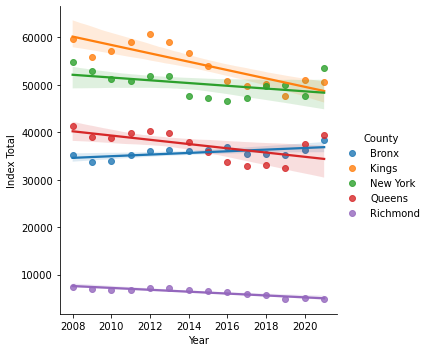

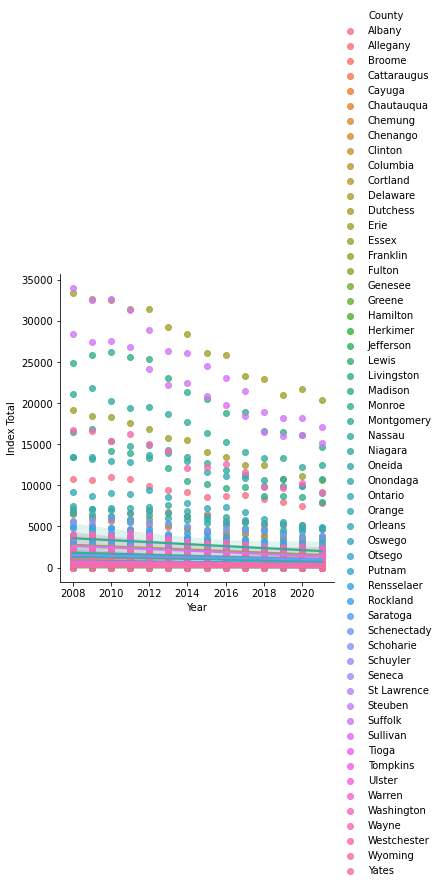

In [16]:
county_crime.groupby(['Region']).apply(plot_by_county)

* After plotting the total reported crimes per county over 14 years, we saw a noticable decrease in crime since 2008.
* As shown from the average_county_crime_df, our plots also show a much higher number of reported crimes in New York City counties compared to counties outside of New York City.

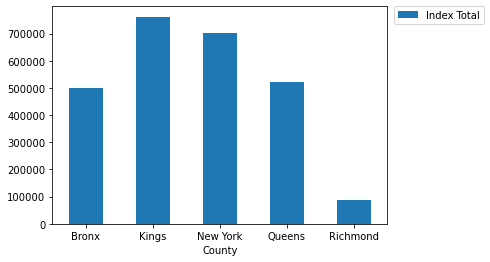

In [17]:
#Creating a bar graph of the total number of crimes reported in each burrough
top5_counties_crime = most_county_crime.groupby(['County']).sum()
plot1 = top5_counties_crime.plot.bar(y = 'Index Total', rot=0)
plot1.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

* Across all years from 2008 to 2021, Kings County/Brooklyn has the highest total number of reported crimes.

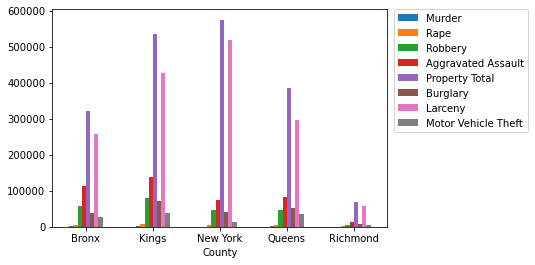

In [19]:
#Separating the total number of crimes reported in each burrough by crime type
type_of_crime_drop_cols = ['Year', 'Violent Total', 'Index Total']
counties_by_type_of_crime = top5_counties_crime.drop(type_of_crime_drop_cols, axis = 1)
counties_by_type_of_crime
plot2 = counties_by_type_of_crime.plot.bar(rot=0)
plot2.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

* Breaking down the total number of crimes by type, it is clear that Property and Larceny Crimes make up most of the reported crimes. 
* In New York County (Manhatten), the total number of Property Crimes reported is particular high.

In [20]:
#Creating a dataset with the total number of arrests for 
#each type of crime
%sql num_of_arrests << SELECT OFNS_DESC, COUNT(*) AS "Number of Arrests" \
FROM nypd_arrests \
GROUP BY OFNS_DESC \
ORDER BY "Number of Arrests" DESC 

Returning data to local variable num_of_arrests


['DANGEROUS DRUGS', 'ASSAULT 3 & RELATED OFFENSES', 'OTHER OFFENSES RELATED TO THEFT', 'PETIT LARCENY', 'OTHER STATE LAWS', 'FELONY ASSAULT', 'VEHICLE AND TRAFFIC LAWS', 'DANGEROUS WEAPONS', 'MISCELLANEOUS PENAL LAW', 'CRIMINAL TRESPASS']


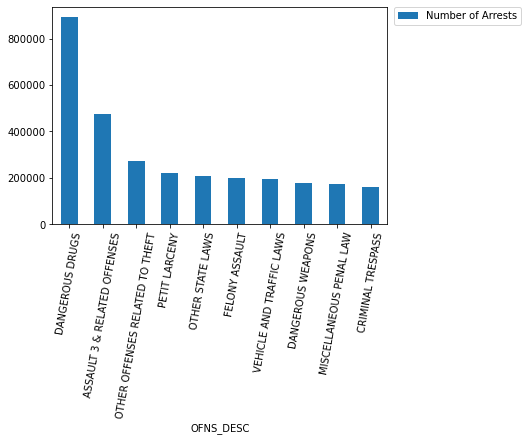

In [21]:
#Creating a bar graph of the top 10 types of arrests in NYC
top_arrests = num_of_arrests.nlargest(10, 'Number of Arrests')
top_crime_arrests = top_arrests['OFNS_DESC'].values.tolist()
print(top_crime_arrests)
plot3 = top_arrests.plot.bar(x = 'OFNS_DESC', rot=0)
plot3.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xticks(rotation = 80)
plt.show()

* The crimes with the highest number of arrests include Dangerous Drugs, Assault, Theft, and Petit Larceny.
* While some of the arrests are due to highly-reported crimes (i.e. Assault, Petit Larceny), others are not. 
* Surprisingly, the most reported type of crime in NYC, Property Crime, is not the crime with the highest number arrests; the crime with the highest historical number of arrests in NYC is Drug Possession and/or Sale.

In [22]:
#Creating a dataset with data from just the top 10 types of crime with the 
#highest number of arrests
%sql arrests_over_time << SELECT YEAR, ARREST_BORO, OFNS_DESC, COUNT(*) AS 'Number of Arrests' \
FROM nypd_arrests \
WHERE OFNS_DESC IN ('DANGEROUS DRUGS', 'ASSAULT 3 & RELATED OFFENSES',\
'OTHER OFFENSES RELATED TO THEFT', 'PETIT LARCENY', 'OTHER STATE LAWS',\
'FELONY ASSAULT', 'VEHICLE AND TRAFFIC LAWS', 'DANGEROUS WEAPONS',\
'MISCELLANEOUS PENAL LAW', 'CRIMINAL TRESPASS')\
GROUP BY YEAR, ARREST_BORO, OFNS_DESC \
ORDER BY "Number of Arrests" DESC
arrests_over_time

Returning data to local variable arrests_over_time


,YEAR,ARREST_BORO,OFNS_DESC,Number of Arrests
0,2009,K,DANGEROUS DRUGS,34427
1,2010,K,DANGEROUS DRUGS,33625
2,2011,K,DANGEROUS DRUGS,33624
3,2008,B,DANGEROUS DRUGS,33576
4,2009,B,DANGEROUS DRUGS,32612
...,...,...,...,...
683,2009,None,DANGEROUS DRUGS,2
684,2008,None,OTHER OFFENSES RELATED TO THEFT,1
685,2020,S,OTHER STATE LAWS,1
686,2008,None,DANGEROUS DRUGS,1


In [23]:
def plot_by_crime(data):
    return sns.lmplot(x= "YEAR", y= "Number of Arrests", hue = 'OFNS_DESC',data=data)

ARREST_BORO
B    <seaborn.axisgrid.FacetGrid object at 0x1a3e92...
K    <seaborn.axisgrid.FacetGrid object at 0x1a3e92...
M    <seaborn.axisgrid.FacetGrid object at 0x1a3eed...
Q    <seaborn.axisgrid.FacetGrid object at 0x1a3f2b...
S    <seaborn.axisgrid.FacetGrid object at 0x1a3e2b...
dtype: object

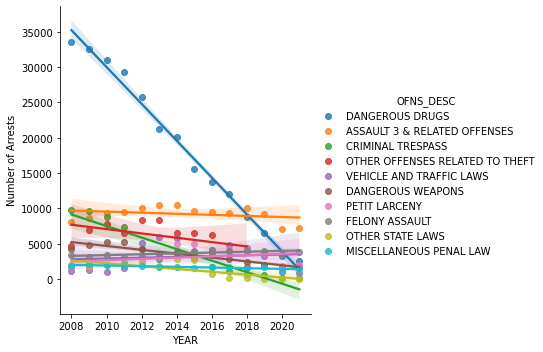

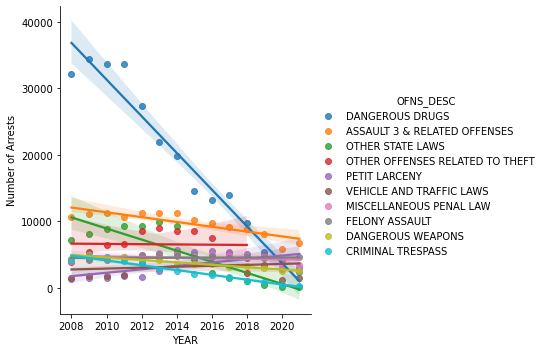

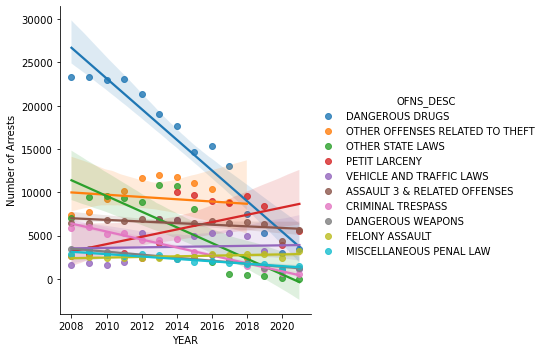

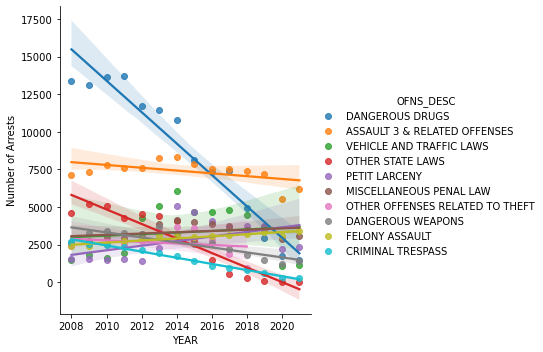

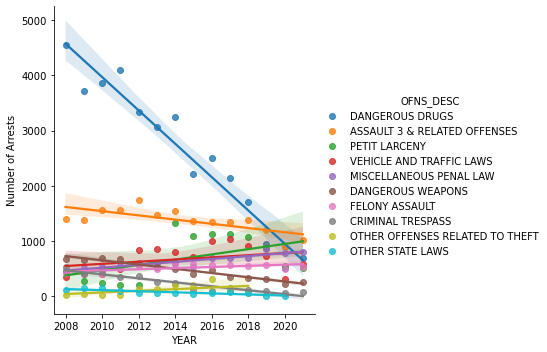

In [24]:
arrests_over_time.groupby(['ARREST_BORO']).apply(plot_by_crime)

* After plotting the total number of arrests per burrough over 14 years, we saw a noticable decrease in drug-related arrests since 2008.
* In 2008, the total number of drug-related arrests in each burrough were double, nearly double, or more than double the number of arrests from the next nine types of crime with the highest number of arrests.
* The amount of drug-related arrests have since decreased, and in 2021, were at a level comparable to other types of arrests.

In [25]:
#Preparing a dataset to examine the demographics of the drug-related arrests
%sql drug_arrests << SELECT AGE_GROUP, PERP_SEX, PERP_RACE, COUNT(*) AS "Number of Arrests" \
FROM nypd_arrests \
WHERE OFNS_DESC = 'DANGEROUS DRUGS' \
GROUP BY AGE_GROUP, PERP_SEX, PERP_RACE \
ORDER BY "Number of Arrests" DESC
drug_arrests

Returning data to local variable drug_arrests


,AGE_GROUP,PERP_SEX,PERP_RACE,Number of Arrests
0,25-44,M,BLACK,157789
1,18-24,M,BLACK,95836
2,45-64,M,BLACK,95119
3,25-44,M,WHITE HISPANIC,91644
4,18-24,M,WHITE HISPANIC,59986
...,...,...,...,...
69,1042,M,WHITE HISPANIC,1
70,65+,F,UNKNOWN,1
71,937,M,BLACK,1
72,935,M,BLACK,1


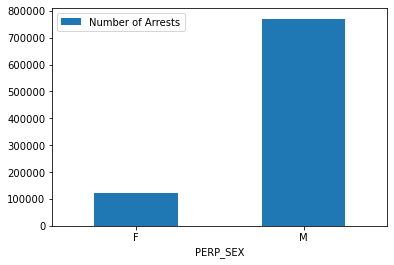

In [26]:
#Creating a bar graph of the total number of drug-related arrests by sex
m_f = drug_arrests.groupby('PERP_SEX').sum()
m_f = m_f.reset_index(level = 0)
plot4 = m_f.plot.bar(x = 'PERP_SEX', rot = 0)

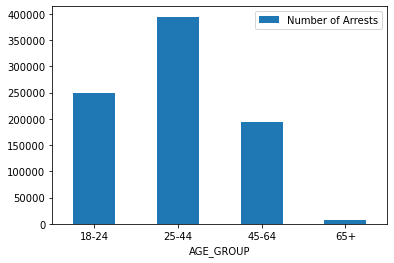

In [27]:
#Creating a bar graph of the total number of drug-related arrests by age group
age_group = drug_arrests.groupby('AGE_GROUP').sum()
age_group = age_group.reset_index(level = 0)
age_group['AGE_GROUP'] = age_group['AGE_GROUP'].astype(str)
ages = ('18-24', '25-44', '45-64', '65+')
age_group = age_group[age_group['AGE_GROUP'].isin(ages)]
plot5 = age_group.plot.bar(x = 'AGE_GROUP', y = 'Number of Arrests', rot=0)


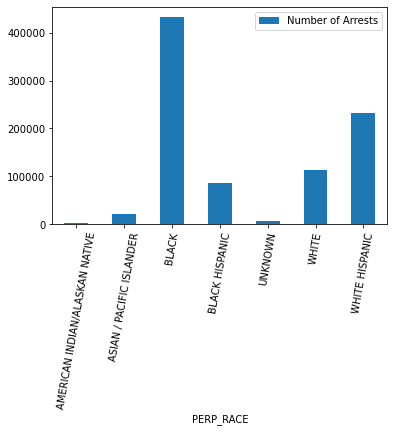

In [28]:
#Creating a bar graph of the total number of drug-related arrests by race
race = drug_arrests.groupby('PERP_RACE').sum()
race = race.reset_index(level = 0)
plot6 = race.plot.bar(x = 'PERP_RACE', rot = 0)
plt.xticks(rotation = 80)
plt.show()

* Based on the above three graphs, Black males, aged 25-44, are the most likely demographic to be arrested for Dangerous Drugs in NYC.

__Questions for reviewers:__
1. Based what we have already written, is there a better way to order/organize our visualizations to tell a more coherent story?
2. Much of our data is not directly related, so how would you recommend us to think about coming up with a research question that relates the variables present in our datasets?
3. We are thinking about adding a linear regression to forecast future rates of crime in our line plots. Would this be necessary? We are concerned it may muddle/de-emphasize the focus on NYC arrest demographics in the latter half of our report. 
4. Are we allowed to revise/add onto our research questions before or after we submit Phase III of our report?
5. Should our research questions be focused more on a correlative relationship between variables, or can it be more broad (similar to how we worded our questions in this draft?)